In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import pad_sequences


SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

c:\Users\alexy\environments\dsai-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Train and Test data

In [2]:
#import the train and test files for financial news
fnews_Xtrain = pd.read_csv('data/train/fnews_Xtrain.csv')
fnews_Xtest = pd.read_csv('data/test/fnews_Xtest.csv')
fnews_ytrain = pd.read_csv('data/train/fnews_ytrain.csv')
fnews_ytest = pd.read_csv('data/test/fnews_ytest.csv')

In [3]:
# drop the first column for all the train and test sets
fnews_Xtrain.drop(columns=fnews_Xtrain.columns[0], axis=1, inplace=True)
fnews_ytrain.drop(columns=fnews_ytrain.columns[0], axis=1, inplace=True)
fnews_Xtest.drop(columns=fnews_Xtest.columns[0], axis=1, inplace=True)
fnews_ytest.drop(columns=fnews_ytest.columns[0], axis=1, inplace=True)

In [4]:
#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 1) ytrain: (3876, 1)
Xtest: (970, 1) ytest: (970, 1)


In [5]:
fnews_Xtrain.head()

,News
0,"['russia', 'raisio', 's', 'food', 'division', ..."
1,"['operator', 'need', 'learn', 'use', 'device',..."
2,"['company', 'expects', 'net', 'sale', 'half', ..."
3,"['bridge', 'km', 'long', 'located', 'anasmotet..."
4,"['nokia', 'capcom', 'announced', 'resident', '..."


In [6]:
MAX_LEN = max([len(x) for x in fnews_Xtrain["News"]])

In [7]:
fnews_Xtrain['News'] = fnews_Xtrain['News'].apply(eval)
fnews_Xtest['News'] = fnews_Xtest['News'].apply(eval)

# BERT Model

BERT is a trained Transformer Encoder stack. We will be using both the base and the large version from huggingface, and choose the best model.

In transformers, we can access many different versions of pre-trained BERT models:

    BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters

    BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters

    BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters

    BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters

    BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters

    BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:
- input ids: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- attention mask: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- labels: a single value of -1, 0 or 1. In our task -1 means "negative", 0 means "neutral", and 1 means "positive".

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) pad_sequences is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.


In [73]:
from transformers import BertConfig, TFBertModel, BertTokenizer, TFBertForSequenceClassification, TFDistilBertModel, TFAutoModelForSequenceClassification

In [60]:
def create_attention_masks(sentence):
    """ Creating the specifically formatted inputs for BERT. """
    # load the pre-trained tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    # initialise the input arrays
    input_ids = []
    token_type_ids = []
    attention_masks = []
    # iterate through the sentences to generate the inputs for BERT
    for headline in sentence:
        tokenized_texts = tokenizer.encode_plus(" ".join(headline),
                                                    add_special_tokens=True,
                                                    max_length=MAX_LEN,
                                                    padding='max_length',
                                                    truncation=True,
                                                    return_attention_mask=True)
        input_ids.append(tokenized_texts['input_ids'])
        token_type_ids.append(tokenized_texts['token_type_ids'])
        attention_masks.append(tokenized_texts['attention_mask'])
   
    return input_ids, token_type_ids, attention_masks

MAX_LENGTH =  20
ORIGINAL SENTENCE:  I love CZ4042!
input_ids:  [101, 1045, 1048, 1051, 1058, 1041, 1039, 1062, 1018, 1014, 1018, 1016, 999, 102, 0, 0, 0, 0, 0, 0]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
token_type_ids:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# ttrain_inputs_scaled = scaler.fit_transform(ttrain_inputs)
# val_inputs_scaled = scaler.transform(val_inputs)
# test_inputs_scaled = scaler.transform(test_inputs)

In [61]:
# mapping the classes to a numeric representation
train_labels = fnews_ytrain['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values
test_labels = fnews_ytest['Class'].map({'neutral':1, 'positive': 2, 'negative': 0}).values

In [96]:
train_input_ids, train_tokens, train_attention_masks = create_attention_masks(fnews_Xtrain['News'])
test_input_ids, test_tokens, test_attention_masks = create_attention_masks(fnews_Xtest['News'])
ttrain_input_ids, val_input_ids, ttrain_tokens, val_tokens, ttrain_attention_masks, val_attention_masks, ttrain_labels, val_labels  = train_test_split(train_input_ids, train_tokens, train_attention_masks, train_labels, test_size=0.2)
print('Train shape: ', len(ttrain_input_ids), len(ttrain_tokens), len(ttrain_attention_masks), len(ttrain_labels))
print('Val shape: ', len(val_input_ids), len(val_tokens), len(val_attention_masks), len(val_labels))
print('Test shape: ', len(test_input_ids), len(test_tokens), len(test_attention_masks), len(test_labels))

Train shape:  3100 3100 3100 3100
Val shape:  776 776 776 776
Test shape:  970 970 970 970


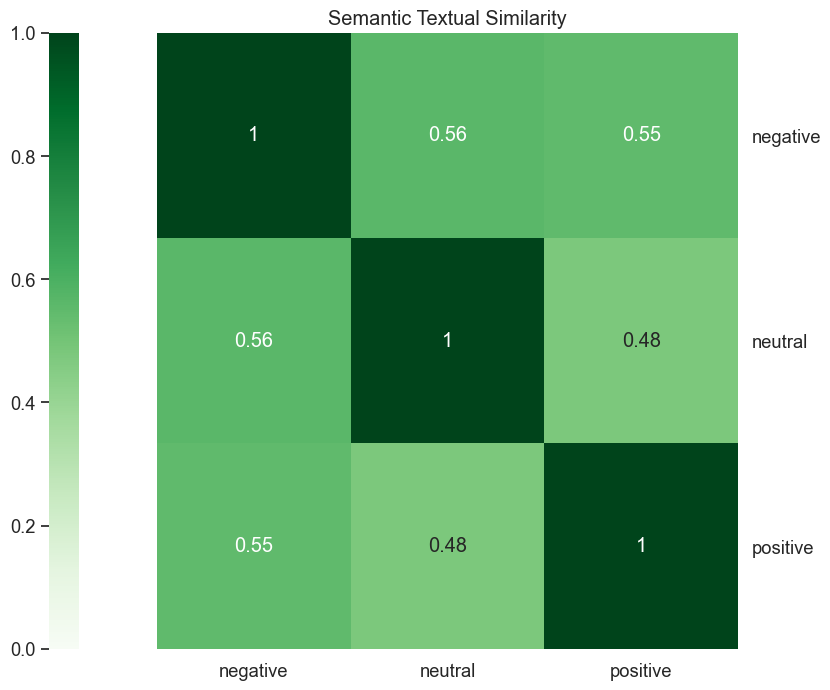

In [97]:
# looking at the textual similarity
from sklearn.metrics.pairwise import cosine_similarity
import random

def plot_similarity(features, labels, title='Semantic Textual Similarity'):
  """
  Plot a similarity matrix of the embeddings.
  Reference code taken from: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d
  """
  plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cosine_similarity(features), xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Greens", 
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title(title)

sentiments = ["negative", "neutral", "positive"]

# comparing a random sample from each
neg_samples = np.array(ttrain_input_ids)[ttrain_labels==0]
neu_samples = np.array(ttrain_input_ids)[ttrain_labels==1]
pos_samples = np.array(ttrain_input_ids)[ttrain_labels==2]
plot_similarity([
  neg_samples[random.randint(0, len(neg_samples)-1)], 
  neu_samples[random.randint(0, len(neu_samples)-1)], 
  pos_samples[random.randint(0, len(pos_samples)-1)]
  ], sentiments)

In [ ]:
# repeating for all samples

        
def plot_overall_similarity(features, labels, title='Semantic Textual Similarity'):
    """
    Plot a similarity matrix of the embeddings.
    Reference code taken from: https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d
    """
    neg_cosine_sim = []
    for x in neg_samples:
        for y in neg_samples:
            neg_cosine_sim.append(cosine_similarity([x,y]))
    pos_cosine_sim = []
    for x in pos_samples:
        for y in pos_samples:
            pos_cosine_sim.append(cosine_similarity([x,y]))
    neu_cosine_sim = []
    for x in neu_samples:
        for y in neu_samples:
            neu_cosine_sim.append(cosine_similarity([x,y]))
            
    plt.figure(figsize=(10,8))
    sns.set(font_scale=1.2)
    cbar_kws=dict(use_gridspec=False, location="left")
    g = sns.heatmap(
        similarities, xticklabels=labels, yticklabels=labels,
        vmin=0, vmax=1, annot=True, cmap="Greens", 
        cbar_kws=cbar_kws)
    g.tick_params(labelright=True, labelleft=False)
    g.set_yticklabels(labels, rotation=0)
    g.set_title(title)

In [63]:
NUM_CLASSES = 3
ttrain_inputs = tf.convert_to_tensor(ttrain_input_ids, dtype=tf.int32, name='input_ids')
val_inputs = tf.convert_to_tensor(val_input_ids, dtype=tf.int32, name='input_ids')
test_inputs = tf.convert_to_tensor(test_input_ids, dtype=tf.int32, name='input_ids')

ttrain_tokens = tf.convert_to_tensor(ttrain_tokens,dtype=tf.int32, name='token_ids')
val_tokens = tf.convert_to_tensor(val_tokens, dtype=tf.int32, name='token_ids')
test_tokens = tf.convert_to_tensor( test_tokens, dtype=tf.int32, name='token_ids')


# ttrain_labels = tf.convert_to_tensor(ttrain_labels)
# val_labels = tf.convert_to_tensor(val_labels)
# test_labels = tf.convert_to_tensor(test_labels)

ttrain_labels = tf.keras.utils.to_categorical(ttrain_labels, num_classes=NUM_CLASSES)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=NUM_CLASSES)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=NUM_CLASSES)

ttrain_masks = tf.convert_to_tensor(ttrain_attention_masks, dtype=tf.int32, name='attention_masks')
val_masks = tf.convert_to_tensor(val_attention_masks, dtype=tf.int32, name='attention_masks')
test_masks = tf.convert_to_tensor(test_attention_masks, dtype=tf.int32, name='attention_masks')

In [15]:
def map_to_dict(inputs, masks, tokens, labels):
    return {
        'input_ids': inputs,
        'attention_masks': masks,
        'token_ids': tokens,
    }, labels

In [64]:
BATCH_SIZE = 8
train_ds = tf.data.Dataset.from_tensor_slices((ttrain_inputs, ttrain_masks, ttrain_tokens, ttrain_labels)).map(map_to_dict).shuffle(len(ttrain_inputs)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_masks, val_tokens, val_labels)).map(map_to_dict).shuffle(len(val_inputs)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_masks, test_tokens, test_labels)).map(map_to_dict).shuffle(len(test_inputs)).batch(BATCH_SIZE)

## Using the Distilled BERT Model

In [80]:
## Initialize pre-built BERT-based classifier from transformers
def create_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    # tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 
    inputs = [ids, masks]
    config = BertConfig()
    config.output_hidden_states = False
    bert_model = TFAutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    # outputs = bert_model(input_ids=ids, attention_mask=masks, token_type_ids=tokens)
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

In [85]:
epochs = 3
learning_rate = 3e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
bert_model = create_base_model()
# bert_model = TFBertForSequenceClassification.from_pretrained(
#         'bert-base-uncased', num_labels=NUM_CLASSES)
bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=[metrics],
                   )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['vocab_transform', 'activation_13', 'distilbert', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 345)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 345)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109483778  ['input_ids[0][0]',              
 ation_7 (TFBertForSequenceClas  rOutput(loss=None,               'attention_masks[0][0]']        
 sification)                    logits=(None, 2),                                                 
                                 hidden_states=None                                         

In [87]:
from datetime import datetime
from tensorflow.keras.callbacks import Callback
log_dir = "bert-distilled/fit/" + f'base-model/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

te = time_for_epoch()      
base_model_history = bert_model.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds, 
                         callbacks=[tensorboard_callback, te, es]
                         )

Epoch 1/3
  1/388 [..............................] - ETA: 40:42 - loss: 0.9111 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000

KeyboardInterrupt: 

## Using the Base BERT Model

In [ ]:
## Initialize pre-built BERT-based classifier from transformers
def create_base_model():
    ids = keras.layers.Input(shape=((MAX_LEN,)), name="input_ids", dtype="int32")
    # tokens = keras.layers.Input(shape=((MAX_LEN,)), name="token_ids", dtype="int32")
    masks = keras.layers.Input(shape=((MAX_LEN,)), name="attention_masks", dtype="int32") 
    inputs = [ids, masks]
    config = BertConfig()
    config.output_hidden_states = False
    bert_model = TFBertModel.from_pretrained(
        'bert-base-uncased', config=config)
    
    embedded_layer = bert_model(ids, attention_mask=masks)[0]
    outputs = keras.layers.Dense(3, activation='softmax')(embedded_layer)
    
    # outputs = bert_model(input_ids=ids, attention_mask=masks, token_type_ids=tokens)
    bert_model = keras.Model(inputs, outputs)  
    bert_model.summary()
    return bert_model

## Creating more inputs by using Back Translation

In [ ]:
from translate import Translator
translator_1 = Translator(from_lang="en", to_lang="de")
translator_2 = Translator(from_lang="de", to_lang="en")

# Squid Game Reviews

In [88]:
sg_Xtrain = pd.read_csv('data/train/squidgame_Xtrain.csv', index_col=0)   
sg_Xtest = pd.read_csv('data/test/squidgame_Xtest.csv', index_col=0) 
sg_ytrain = pd.read_csv('data/train/squidgame_ytrain.csv', index_col=0) 
sg_ytest = pd.read_csv('data/test/squidgame_ytest.csv', index_col=0) 

In [89]:
# mapping the classes to a numeric representation
sg_train_labels = sg_ytrain['Class'].map({'neutral':0, 'positive': 1, 'negative': -1}).values
sg_test_labels = sg_ytest['Class'].map({'neutral':0, 'positive': 1, 'negative': -1}).values

In [90]:
sg_train_input_ids, sg_train_tokens, sg_train_attention_masks = create_attention_masks(sg_Xtrain['Review'])
sg_test_input_ids, sg_test_tokens, sg_test_attention_masks = create_attention_masks(sg_Xtest['Review'])
sg_ttrain_input_ids, sg_val_input_ids, sg_ttrain_tokens, sg_val_tokens, sg_ttrain_attention_masks, sg_val_attention_masks, sg_ttrain_labels, sg_val_labels  = train_test_split(sg_train_input_ids, sg_train_tokens, sg_train_attention_masks, sg_train_labels, test_size=0.2)
print('Train shape: ', len(sg_ttrain_input_ids), len(sg_ttrain_tokens), len(sg_ttrain_attention_masks), len(sg_ttrain_labels))
print('Val shape: ', len(sg_val_input_ids), len(sg_val_tokens), len(sg_val_attention_masks), len(sg_val_labels))
print('Test shape: ', len(sg_test_input_ids), len(sg_test_tokens), len(sg_test_attention_masks), len(sg_test_labels))

Train shape:  758 758 758 758
Val shape:  190 190 190 190
Test shape:  237 237 237 237


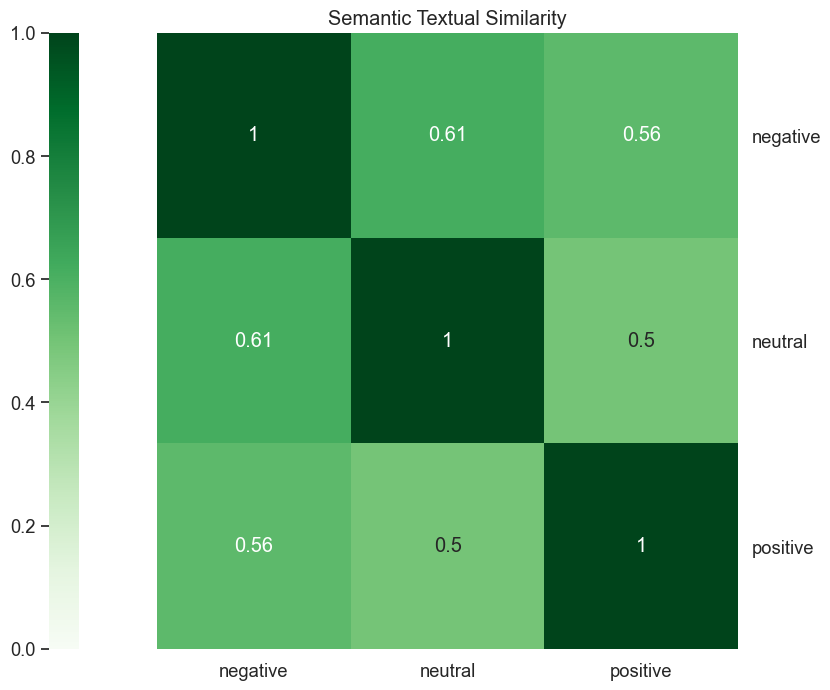

In [91]:
sentiments = ["negative", "neutral", "positive"]

# comparing a random sample from each
sg_neg_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==-1]
sg_neu_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==0]
sg_pos_samples = np.array(sg_ttrain_input_ids)[sg_ttrain_labels==1]
plot_similarity([
  neg_samples[random.randint(0, len(sg_neg_samples)-1)], 
  neu_samples[random.randint(0, len(sg_neu_samples)-1)], 
  pos_samples[random.randint(0, len(sg_pos_samples)-1)]
  ], sentiments)

# Comparing Datasets

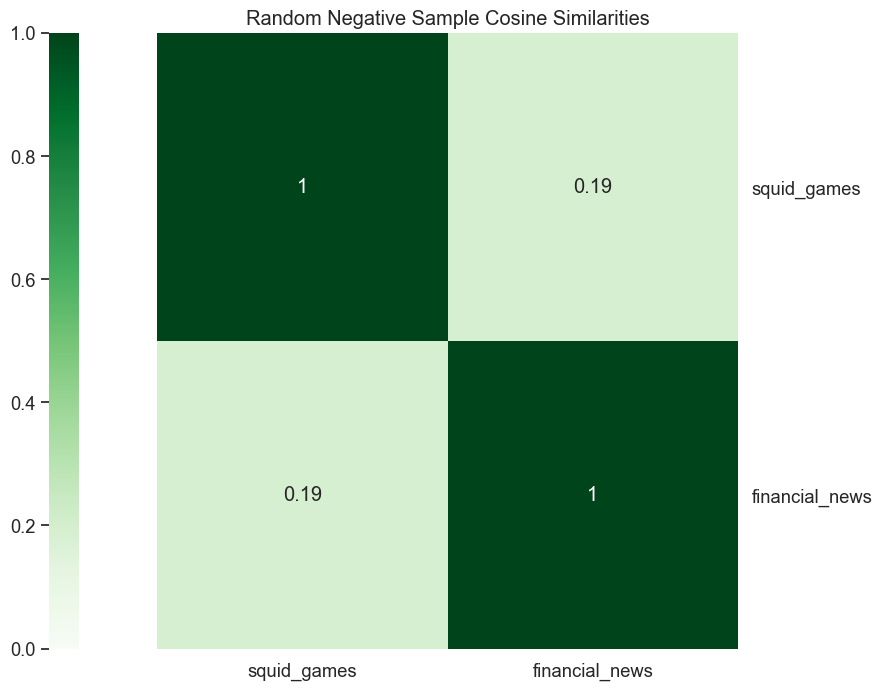

In [104]:
plot_similarity([sg_neg_samples[random.randint(0, len(sg_neg_samples)-1)], neg_samples[random.randint(0, len(neg_samples)-1)]], ['squid_games', 'financial_news'], 'Random Negative Sample Cosine Similarities')

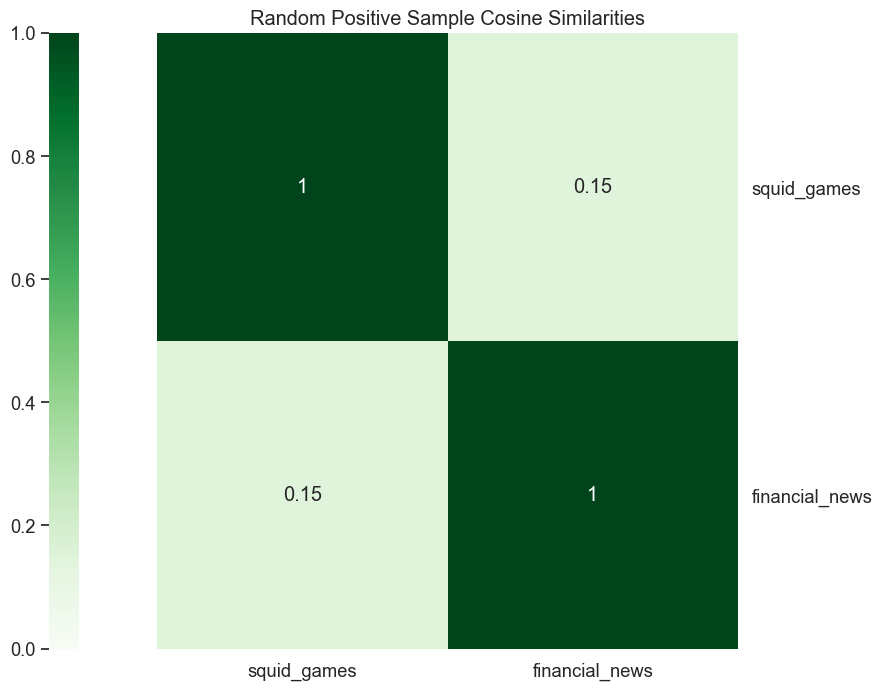

In [103]:
plot_similarity([sg_pos_samples[random.randint(0, len(sg_pos_samples)-1)], pos_samples[random.randint(0, len(pos_samples)-1)]], ['squid_games', 'financial_news'], 'Random Positive Sample Cosine Similarities')

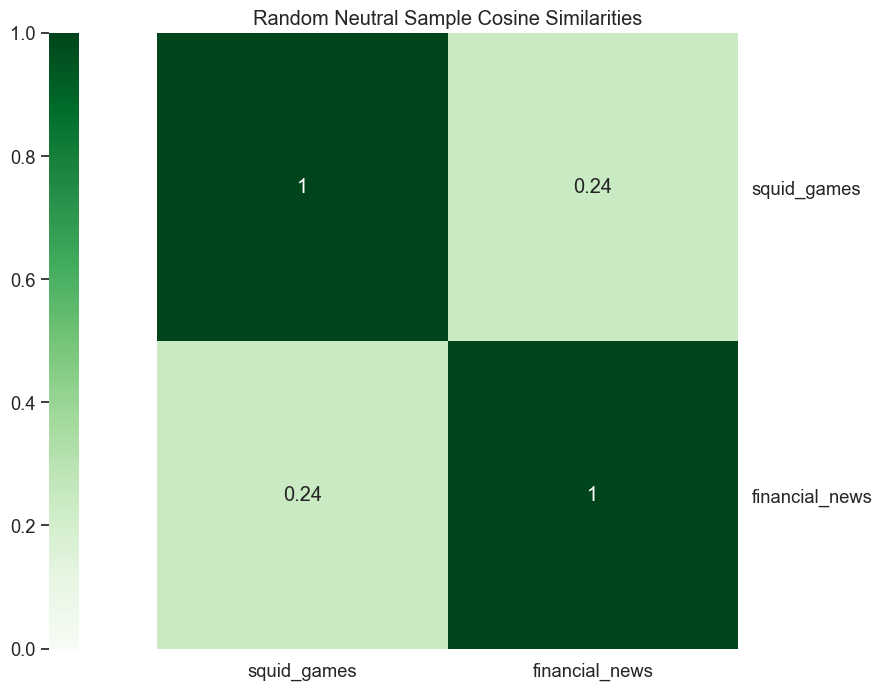

In [105]:
plot_similarity([sg_neu_samples[random.randint(0, len(sg_neu_samples)-1)], neu_samples[random.randint(0, len(neu_samples)-1)]], ['squid_games', 'financial_news'], 'Random Neutral Sample Cosine Similarities')

In [107]:
neg_cosine_sim = []
for x in sg_neg_samples:
    for y in neg_samples:
        neg_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Negative Sentiments in Datasets A and B: ", np.mean(neg_cosine_sim))

Cosine Similarity for Negative Sentiments in Datasets A and B:  0.5946980405439457


In [109]:
pos_cosine_sim = []
for x in sg_pos_samples:
    for y in pos_samples:
        pos_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Positive Sentiments in Datasets A and B: ", np.mean(pos_cosine_sim))

Cosine Similarity for Positive Sentiments in Datasets A and B:  0.5961562611629646


In [110]:
neu_cosine_sim = []
for x in sg_neu_samples:
    for y in neu_samples:
        neu_cosine_sim.append(cosine_similarity([x,y]))
print("Cosine Similarity for Neutral Sentiments in Datasets A and B: ", np.mean(neu_cosine_sim))

Cosine Similarity for Neutral Sentiments in Datasets A and B:  0.5885126377109223
